# Comparison of GPU Sparse Matrix and GPU Dense Matrix

Below is a description of how the measurement took place:

In [1]:
import pandas as pd
from action_rules import ActionRules

data_frame = pd.read_csv("./../data/telco.csv", sep=";")
data_frame = pd.concat([data_frame] * 20)

def run_mining(data_frame, use_sparse_matrix):
    stable_attributes = ["gender", "SeniorCitizen", "Partner"]
    flexible_attributes = ["PhoneService",
                           "InternetService",
                           "OnlineSecurity",
                           "DeviceProtection",
                           "TechSupport",
                           "StreamingTV"]
    target = 'Churn'
    min_stable_attributes = 2
    min_flexible_attributes = 1  # min 1
    min_undesired_support = 80
    min_undesired_confidence = 0.6
    min_desired_support = 80
    min_desired_confidence = 0.6
    undesired_state = 'Yes'
    desired_state = 'No'

    # Action Rules Mining
    action_rules = ActionRules(
        min_stable_attributes=min_stable_attributes,
        min_flexible_attributes=min_flexible_attributes,
        min_undesired_support=min_undesired_support,
        min_undesired_confidence=min_undesired_confidence,
        min_desired_support=min_desired_support,
        min_desired_confidence=min_desired_confidence,
        verbose=False
    )

    action_rules.fit(
        data=data_frame,
        stable_attributes=stable_attributes,
        flexible_attributes=flexible_attributes,
        target=target,
        target_undesired_state=undesired_state,
        target_desired_state=desired_state,
        use_gpu=True,
        use_sparse_matrix=use_sparse_matrix,
    )

In [2]:
# Start your shell script in the background
import subprocess
import os
import cupy as cp
use_sparse_matrix_list = [True, False]
repeat = range(10)
for use_sparse_matrix in use_sparse_matrix_list:
    for i in repeat:
        cp._default_memory_pool.free_all_blocks()
        print(i)
        # Get the directory where the Jupyter notebook is located
        notebook_directory = os.getcwd()
        # Generate the output log file path in the same directory
        output_log = os.path.join(notebook_directory, 'gpu_memory' + '_sparse_' + str(use_sparse_matrix) + '_' + str(i) + '.log')
        process = subprocess.Popen(["bash", "./log_gpu.sh", output_log], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        run_mining(data_frame, use_sparse_matrix)
        process.terminate()

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [8]:
import re

def extract_last_values(log_file_path):
    last_values = []

    with open(log_file_path, 'r') as file:
        for line in file:
            # Match the lines containing the GPU memory usage
            match = re.search(r'python/\d+\((\d+)M\)', line)
            if match:
                # Extract the memory value in MB
                memory_value = int(match.group(1))
                last_values.append(memory_value)
    
    return last_values

In [21]:
use_sparse_matrix_list = [True, False]
repeat = range(10)
mem_results = {'sparse_False': [], 'sparse_True': []}
for use_sparse_matrix in use_sparse_matrix_list:
    for i in repeat:
        log_file = 'gpu_memory' + '_sparse_' + str(use_sparse_matrix) + '_' + str(i) + '.log'
        memory = extract_last_values(log_file)
        mem_results['sparse_' + str(use_sparse_matrix)].append([0] + memory)
mem_results

{'sparse_False': [[0, 426, 5892, 9108, 9408],
  [0, 426, 5912, 9108, 9408],
  [0, 426, 5912, 9108, 9408],
  [0, 426, 5788, 9108, 9332],
  [0, 426, 5782, 9108, 9408],
  [0, 426, 5868, 9108, 8824],
  [0, 426, 5858, 9108, 9396],
  [0, 426, 5882, 9108, 8972],
  [0, 426, 5892, 9108, 8936],
  [0, 426, 5888, 9108, 8932]],
 'sparse_True': [[0,
   12,
   12,
   12,
   12,
   12,
   550,
   594,
   610,
   622,
   768,
   1008,
   1166,
   1410,
   1680,
   1710,
   1718,
   1764,
   1764,
   1764,
   1764,
   1764,
   1764,
   1764,
   1764,
   1764,
   1764,
   1764,
   1764],
  [0,
   426,
   554,
   594,
   610,
   622,
   850,
   1074,
   1186,
   1418,
   1704,
   1704,
   1736,
   1756,
   1756,
   1756,
   1756,
   1756,
   1756,
   1756,
   1756,
   1756,
   1756,
   1756,
   1756],
  [0,
   426,
   554,
   594,
   610,
   626,
   846,
   1086,
   1188,
   1412,
   1698,
   1702,
   1718,
   1754,
   1754,
   1754,
   1754,
   1754,
   1754,
   1754,
   1754,
   1754,
   1754,
   1754,


In [22]:
import numpy as np
import pandas as pd

finals = {}
for type_array, measurements in mem_results.items():
    # Convert to a DataFrame and pad with NaN
    df = pd.DataFrame(measurements)
    
    # Calculate averages and standard deviations, ignoring NaN values
    averages = df.mean(axis=0)
    std_devs = df.std(axis=0)

    finals[type_array + '_averages'] = averages
    finals[type_array + '_std_devs'] = std_devs
    
    # Display the results
    for i, (avg, std) in enumerate(zip(averages, std_devs), start=1):
        print(f"Position {i}: Average = {avg:.2f}, Std Dev = {std:.2f}")

Position 1: Average = 0.00, Std Dev = 0.00
Position 2: Average = 426.00, Std Dev = 0.00
Position 3: Average = 5867.40, Std Dev = 46.56
Position 4: Average = 9108.00, Std Dev = 0.00
Position 5: Average = 9202.40, Std Dev = 250.27
Position 1: Average = 0.00, Std Dev = 0.00
Position 2: Average = 384.60, Std Dev = 130.92
Position 3: Average = 499.80, Std Dev = 171.40
Position 4: Average = 533.80, Std Dev = 183.35
Position 5: Average = 548.60, Std Dev = 188.55
Position 6: Average = 560.20, Std Dev = 192.63
Position 7: Average = 805.20, Std Dev = 90.62
Position 8: Average = 1034.40, Std Dev = 154.96
Position 9: Average = 1129.80, Std Dev = 182.72
Position 10: Average = 1334.60, Std Dev = 250.42
Position 11: Average = 1608.80, Std Dev = 295.46
Position 12: Average = 1635.60, Std Dev = 220.54
Position 13: Average = 1671.20, Std Dev = 177.69
Position 14: Average = 1723.60, Std Dev = 110.29
Position 15: Average = 1750.60, Std Dev = 25.26
Position 16: Average = 1753.60, Std Dev = 16.05
Position 1

In [29]:
df_final = pd.DataFrame(finals)
df_final.iat[5, 0] = 0
df_final.iat[28, 2] = 0
df_final

,sparse_False_averages,sparse_False_std_devs,sparse_True_averages,sparse_True_std_devs
0,0.0,0.000000,0.0,0.000000
1,426.0,0.000000,384.6,130.918295
2,5867.4,46.562264,499.8,171.395449
3,9108.0,0.000000,533.8,183.352605
4,9202.4,250.270609,548.6,188.552498
5,0.0,NaN,560.2,192.634253
6,NaN,NaN,805.2,90.623519
7,NaN,NaN,1034.4,154.964655
8,NaN,NaN,1129.8,182.716417
9,NaN,NaN,1334.6,250.416631


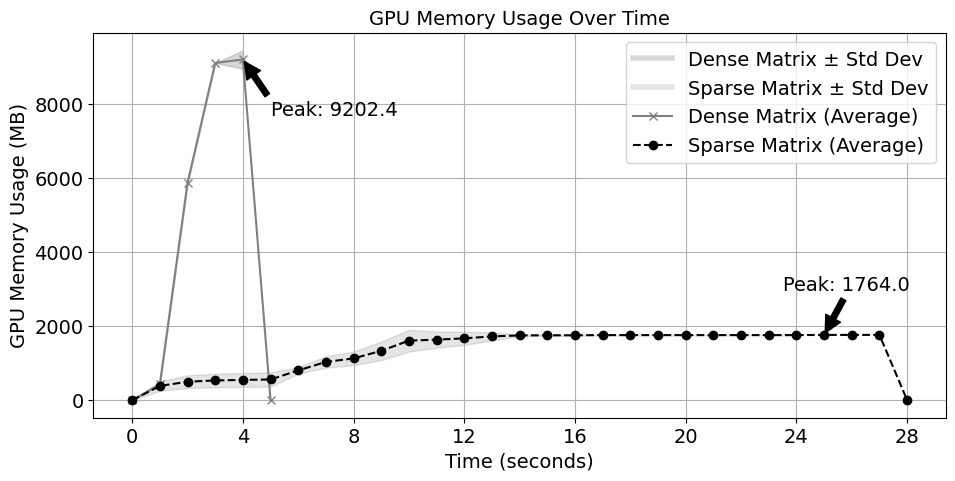

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Assuming df_final is your DataFrame with the columns specified
# Extract the data into variables
dense_memory = df_final["sparse_False_averages"]
dense_std = df_final["sparse_False_std_devs"]
sparse_memory = df_final["sparse_True_averages"]
sparse_std = df_final["sparse_True_std_devs"]

# Plot
plt.figure(figsize=(11, 5))

# Plot dense memory with standard deviation shaded area
plt.plot(df_final.index, dense_memory, label="Dense Matrix (Average)", marker='x', color='gray')
plt.fill_between(df_final.index, dense_memory - dense_std, dense_memory + dense_std, color='gray', alpha=0.3)

# Plot sparse memory with standard deviation shaded area
plt.plot(df_final.index, sparse_memory, label="Sparse Matrix (Average)", marker='o', color='black', linestyle='--')
plt.fill_between(df_final.index, sparse_memory - sparse_std, sparse_memory + sparse_std, color='black', alpha=0.1)

# Highlight peak values
peak_index = dense_memory.idxmax()
peak_value = dense_memory.max()
plt.annotate(f'Peak: {peak_value}', xy=(peak_index, peak_value), xytext=(peak_index + 1, peak_value - 1500),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

peak_index = sparse_memory.idxmax()
peak_value = sparse_memory.max()
plt.annotate(f'Peak: {peak_value}', xy=(peak_index, peak_value), xytext=(peak_index - 1.5, peak_value + 1200),  # Adjusted position to the left
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

# Labels and title
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("GPU Memory Usage (MB)", fontsize=14)
plt.title("GPU Memory Usage Over Time", fontsize=14)
plt.grid(True)

# Custom legend entries for standard deviation areas
std_legend_dense = Line2D([0], [0], color='gray', lw=4, alpha=0.3, label='Dense Matrix ± Std Dev')
std_legend_sparse = Line2D([0], [0], color='black', lw=4, alpha=0.1, label='Sparse Matrix ± Std Dev')

# Set custom x-ticks and y-ticks
plt.xticks(np.arange(min(df_final.index), max(df_final.index) + 1, 4.0), fontsize=14)
plt.yticks(fontsize=14)

# Add legend with custom entries
plt.legend(handles=[std_legend_dense, std_legend_sparse] + plt.gca().get_legend_handles_labels()[0], fontsize=14)

# Save plot
plt.savefig("gpu_memory_usage_with_std_dev.png", format='png', dpi=300)
plt.show()
